In [28]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm


In [29]:
r = 0.00
sig = 0.2
T = 30/365
M = 1000
N = 100
dt = T/N
rdt = r*dt   # r X dt
sigsdt = sig* np.sqrt(dt)   # sigma X   square root

In [30]:
S0 = 1
K = 1
np.random.seed(1234)
S = np.empty([M,N+1])
rv = np.random.normal(r*dt,sigsdt,[M,N] )

In [31]:
for i in range(M):
  S[i,0] = S0
  for j in range(N):
    S[i,j+1] = S[i,j] * (1+rv[i,j])

$\Delta_0 (S_0-S_1) + \Delta_1 (S_1-S_2) + \Delta_2 (S_2-S_3) + \cdots + \Delta_{T-1} (S_{T-1}-S_T) + \Delta_T S_T$

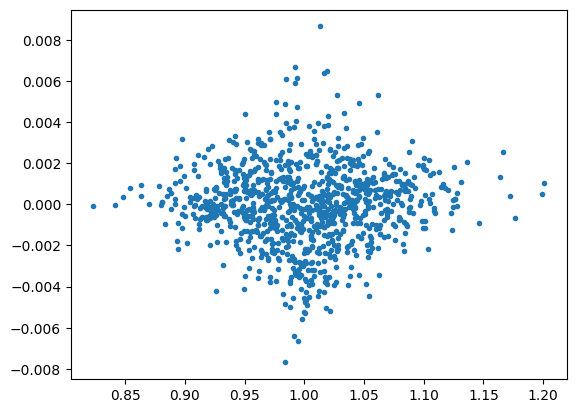

In [6]:
a = []

K = 1

for i in range(M):
  cost= 0
  hedge = 0
  for j in range(N):
    d1 =  (np.log(S[i,j]/K) + (r + 0.5*sig**2)*(T-j*dt))/(sig*np.sqrt(T-j*dt))
    delta = norm.cdf(d1)
    cost = cost + (delta - hedge) * S[i,j]
    hedge = delta
  cost = cost - hedge * S[i,N] + np.maximum(S[i,N]-K,0)
  #cost = cost - hedge * S[i,N]
  a.append(cost)
plt.plot(S[:,-1], a , marker='.', linestyle='')
plt.show()

In [7]:
def bscall(S, K, T, r, sig):
    d1 = (np.log(S/K)+(r+0.5*sig**2)*T)/(sig*np.sqrt(T))
    d2 = (np.log(S/K)+(r-0.5*sig**2)*T)/(sig*np.sqrt(T))
    return S*norm.cdf(d1)-K*np.exp(-r*T)*norm.cdf(d2)

def bsput(S, K, T, r, sig):
    d1 = (np.log(S/K)+(r+0.5*sig**2)*T)/(sig*np.sqrt(T))
    d2 = (np.log(S/K)+(r-0.5*sig**2)*T)/(sig*np.sqrt(T))
    return K*np.exp(-r*T)*norm.cdf(-d2)-S*norm.cdf(-d1)

In [8]:
bscall(S0, K, T, r, sig)

0.02287150628044965

In [9]:
import tensorflow as tf

In [10]:
my_input = []

hedge_cost = tf.keras.layers.Input(shape=(1,), name='hedge_cost')

price = tf.keras.layers.Input(shape=(1,), name='price')
my_input = my_input + [price] +  [hedge_cost]


for j in range(3):
  delta = tf.keras.layers.Dense(1, name=str(j))(price)   #making delta layer

  new_price = tf.keras.layers.Input(shape=(1,), name='S_'+str(j))   # making updated price layer
  my_input = my_input + [new_price]       #change the price to new_price

  price_inc = tf.keras.layers.Subtract(name="price_inc"+str(j))([price,new_price])    #subtract price dfand new price
  cost = tf.keras.layers.Multiply(name="multiply"+str(j))([delta, price_inc])         # multiply delta and price difference
  hedge_cost = tf.keras.layers.Add(name= 'cost_'+str(j))([hedge_cost, cost])          # add cost
  price = new_price


model = tf.keras.Model(inputs=my_input, outputs=hedge_cost)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ price (InputLayer)        │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ S_0 (InputLayer)          │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ 0 (Dense)                 │ (None, 1)              │              2 │ price[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ price_inc0 (Subtract)     │ (None, 1)              │              0 │ price[0][0], S_0[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ S_1 (InputLayer)          │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ hedge_cost (InputLayer)   │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply0 (Multiply)      │ (None, 1)              │              0 │ 0[0][0],               │
│                           │                        │                │ price_inc0[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ 1 (Dense)                 │ (None, 1)              │              2 │ S_0[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ price_inc1 (Subtract)     │ (None, 1)              │              0 │ S_0[0][0], S_1[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ S_2 (InputLayer)          │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cost_0 (Add)              │ (None, 1)              │              0 │ hedge_cost[0][0],      │
│                           │                        │                │ multiply0[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply1 (Multiply)      │ (None, 1)              │              0 │ 1[0][0],               │
│                           │                        │                │ price_inc1[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ 2 (Dense)                 │ (None, 1)              │              2 │ S_1[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ price_inc2 (Subtract)     │ (None, 1)              │              0 │ S_1[0][0], S_2[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cost_1 (Add)              │ (None, 1)              │              0 │ cost_0[0][0],          │
│                           │                        │                │ multiply1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply2 (Multiply)      │ (None, 1)              │              0 │ 2[0][0],               │
│                           │                        │                │ price_inc2[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cost_2 (Add)              │ (None, 1)              │              0 │ cost_1[0][0],          │
│                      

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

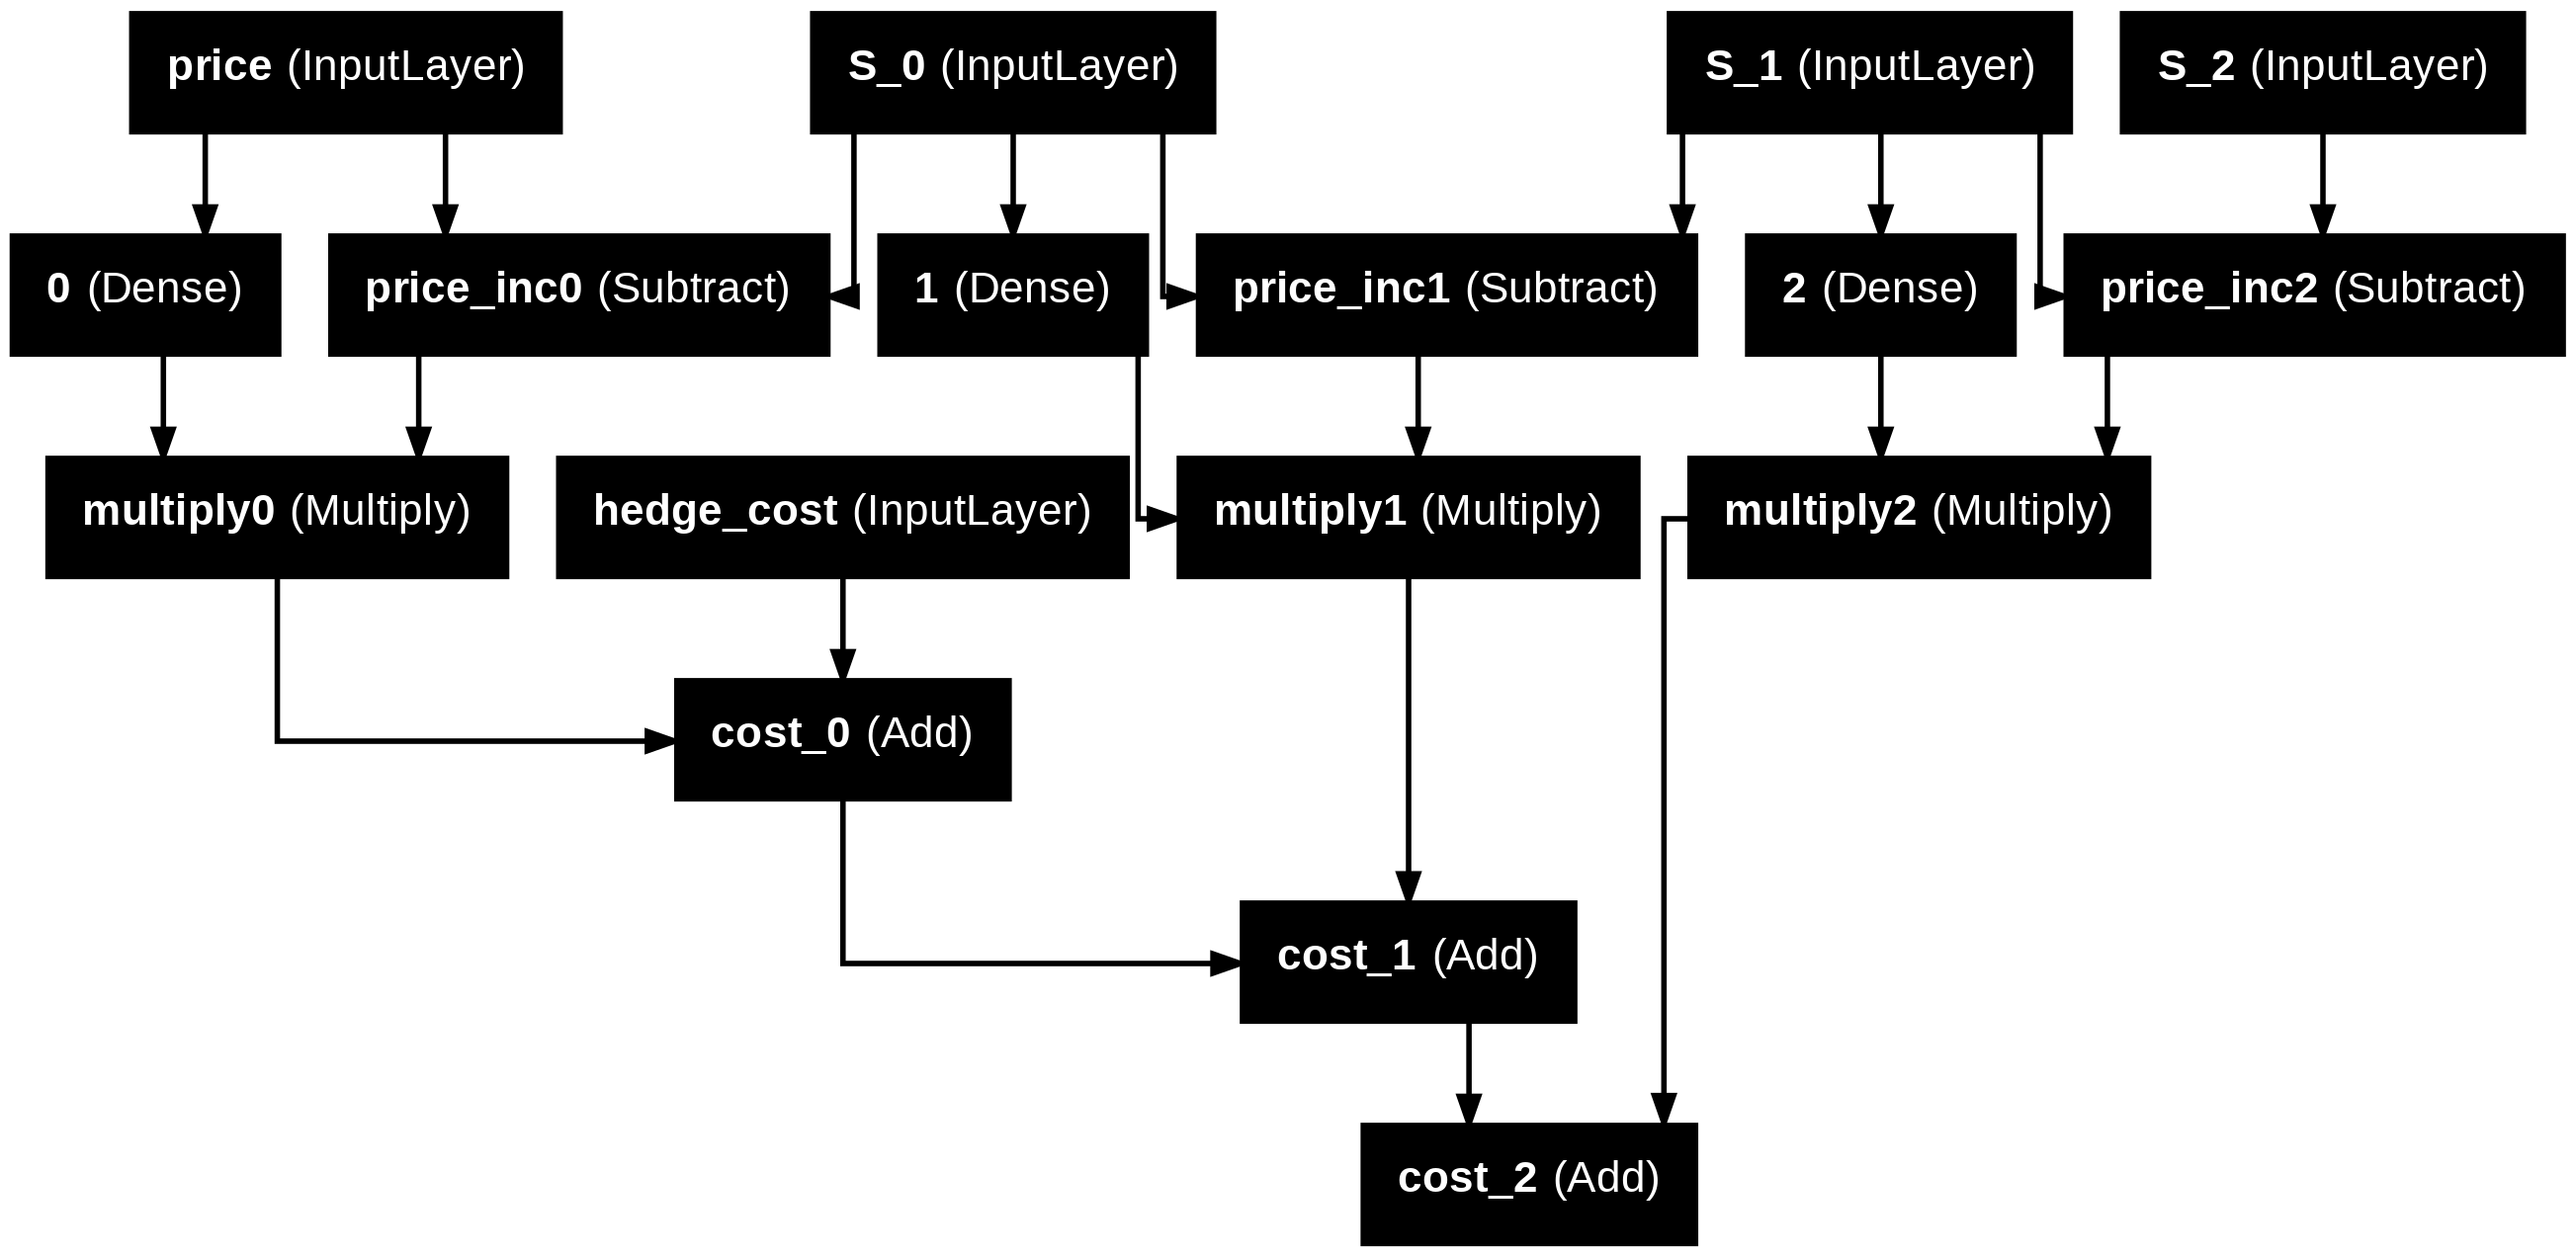

In [11]:
model.summary()
tf.keras.utils.plot_model(model, show_layer_names=True)

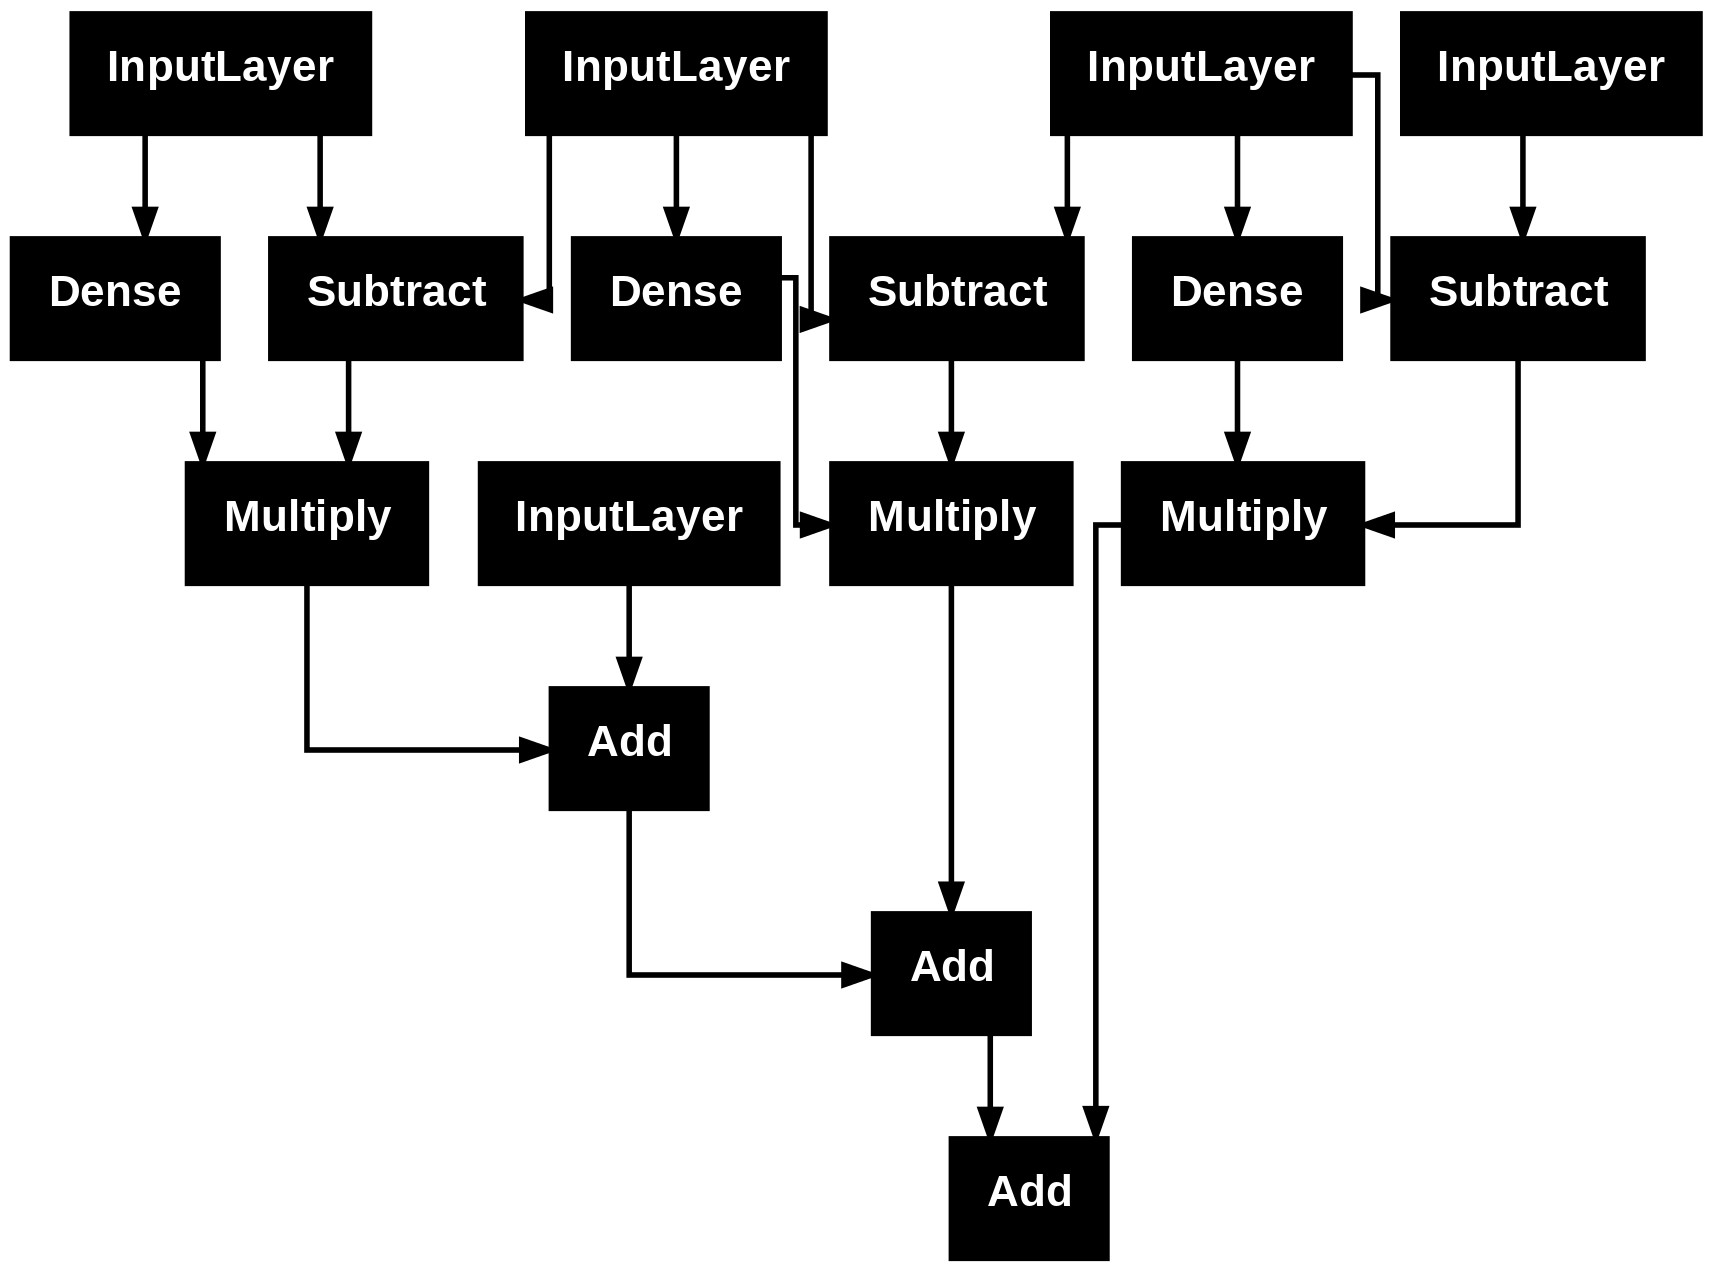

In [12]:
tf.keras.utils.plot_model(model)

In [13]:
my_delta_model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='leaky_relu', input_shape=(1,)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(32, activation='leaky_relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(32, activation='leaky_relu'),
    #delta = tf.keras.layers.Dense(1,activation='sigmoid'),  # for call option
    tf.keras.layers.Dense(1, activation='tanh')  # for put option

])

def minus_sigmoid_scaled(x):
    sigmoid_x = tf.keras.activations.sigmoid(x)
    return -sigmoid_x  # This will map the output to the range [-1, 0]

def delta_model():
  price = tf.keras.Input(shape=(1,))
  delta = tf.keras.layers.Dense(32, activation='leaky_relu')(price)
  delta = tf.keras.layers.BatchNormalization()(delta)
  delta = tf.keras.layers.Dense(32, activation='leaky_relu')(delta)
  delta = tf.keras.layers.BatchNormalization()(delta)
  delta = tf.keras.layers.Dense(32, activation='leaky_relu')(delta)
  delta = tf.keras.layers.Dense(1,activation='tanh')(delta)
  delta = tf.keras.layers.Dense(1, activation=minus_sigmoid_scaled)(delta)

  return tf.keras.Model(inputs=price, outputs=delta)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
# K= 100
my_input = []


premium = tf.keras.layers.Input(shape=(1,), name="premium")
hedge_cost = tf.keras.layers.Input(shape=(1,), name='hedge_cost')
price = tf.keras.layers.Input(shape=(1,), name="price")

my_input = my_input + [premium] + [hedge_cost] + [price]

# for j in range(N):

#     delta = tf.keras.layers.Dense(32, activation='tanh')(price_set)
#     delta = tf.keras.layers.Dense(32, activation='tanh')(price)
#     delta = tf.keras.layers.BatchNormalization()(delta)
#     delta = tf.keras.layers.Dense(32, activation='leaky_relu')(delta)
#     delta = tf.keras.layers.BatchNormalization()(delta)
#     delta = tf.keras.layers.Dense(32, activation='leaky_relu')(delta)
#     delta = tf.keras.layers.Dense(1)(delta)

for j in range(N):

    # #delta = tf.keras.layers.Dense(32, activation='tanh')(price_set)
    # delta = tf.keras.layers.Dense(32, activation='leaky_relu')(price)
    # delta = tf.keras.layers.BatchNormalization()(delta)
    # delta = tf.keras.layers.Dense(32, activation='leaky_relu')(delta)
    # delta = tf.keras.layers.BatchNormalization()(delta)
    # delta = tf.keras.layers.Dense(32, activation='leaky_relu')(delta)
    # #delta = tf.keras.layers.Dense(1,activation='sigmoid')(delta)  # for call option
    # delta = tf.keras.layers.Dense(1, activation=minus_sigmoid_scaled)(delta)  # for put option
    #delta = my_delta_model(price)
    delta = delta_model()(price)

    new_price = tf.keras.layers.Input(shape=(1,), name='S'+str(j+1))
    my_input = my_input + [new_price]

    price_inc = tf.keras.layers.Subtract(name='price_inc_'+str(j))([price, new_price])
    cost = tf.keras.layers.Multiply(name="stock_"+str(j))([delta, price_inc])
    hedge_cost = tf.keras.layers.Add(name='cost_'+str(j))([hedge_cost, cost])
    #info_set = tf.keras.layers.Concatenate()([price, new_price])
    price = new_price



#payoff = tf.keras.layers.Lambda(lambda x : tf.math.maximum(x-K,0), name='payoff')(price) # call option
payoff = tf.keras.layers.Lambda(lambda x : tf.math.maximum(K-x,0), name='payoff')(price) # put  option

cum_cost = tf.keras.layers.Add(name="hedge_cost_plus_payoff")([hedge_cost, payoff])
cum_cost = tf.keras.layers.Subtract(name="cum_cost-premium")([cum_cost, premium])

model = tf.keras.Model(inputs=my_input, outputs=cum_cost)


In [17]:
tf.keras.utils.plot_model(model)

KeyboardInterrupt: 

In [18]:
premium = bscall(S0,K,T,r,sig) * np.ones([M,1])
#premium = bsput(S0,K,T,r,sig) * np.ones([M,1]) # for pution premium value
cost = np.zeros([M,1])
SS = [S[:,i].reshape(M,1) for i in range(N+1)]
x = [premium]+[cost]+[SS]
y = np.zeros([M,1])


In [19]:
model.compile(loss='mse', optimizer='adam')

In [20]:
hist = model.fit(x,y, batch_size=32, epochs=100, verbose=True, validation_split=0.2)

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 360s 2s/step - loss: 2.8459e-04 - val_loss: 2.8569e-04
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - loss: 1.3025e-04 - val_loss: 2.8438e-04
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step - loss: 1.0118e-04 - val_loss: 2.8377e-04
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 212ms/step - loss: 9.7982e-05 - val_loss: 2.8272e-04
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - loss: 8.7881e-05 - val_loss: 2.8074e-04
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - loss: 9.4407e-05 - val_loss: 2.7864e-04
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - loss: 8.2263e-05 - val_loss: 2.7612e-04
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - loss: 8.0493e-05 - val_loss: 2.7121e-04
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - loss: 7.7169e-05 - val_loss: 2.6253e-04
Epoch 10/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - loss: 7.4242e-05 - val_loss: 2.5363e-04
Epoch 11/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 107ms/st

32/32 ━━━━━━━━━━━━━━━━━━━━ 40s 623ms/step


(array([  3.,  17.,  75., 225., 342., 242.,  73.,  17.,   4.,   2.]),
 array([-0.02841844, -0.02223087, -0.01604329, -0.00985572, -0.00366815,
         0.00251943,  0.008707  ,  0.01489458,  0.02108215,  0.02726972,
         0.0334573 ]),
 <BarContainer object of 10 artists>)

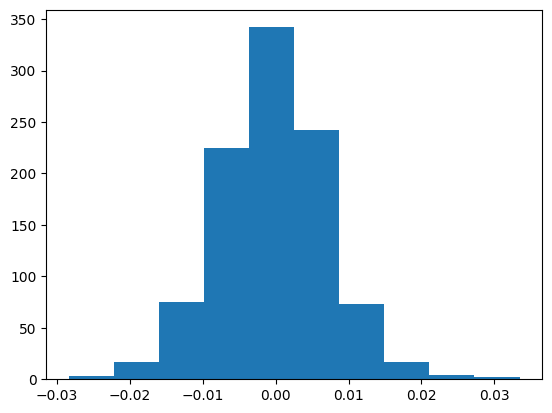

In [21]:
plt.hist(model.predict(x))


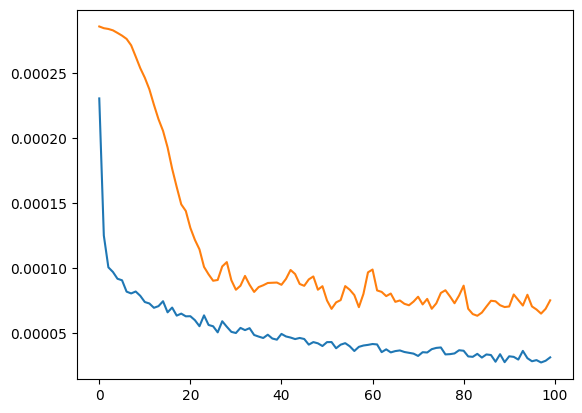

In [25]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.show()

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


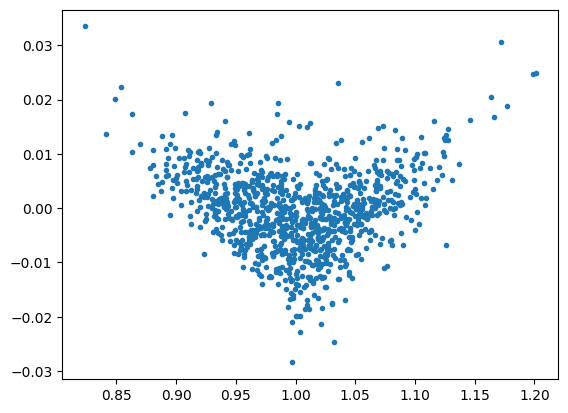

In [23]:
plt.plot(S[:,-1], model.predict(x), marker = ".", linestyle='none')
plt.show()